In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_arrays as ua
import datetime
import matplotlib.colors as mcolors
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from utils import u_plot as uplot
import salem
import numpy.ma as ma
from scipy import stats
import warnings
from scipy.ndimage.measurements import label

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
fpath = cnst.network_data + 'figs/HUARAZ/'

In [3]:
corr_all = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_SouthAmerica_1985-2018_diffs.nc')
corr_first = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_SouthAmerica_1985-2004_diffs.nc')
corr_end = xr.open_dataset('/home/ck/DIR/mymachine/GRIDSAT/MCS18_peru/correlations/GRIDSAT-15_u_correlation_SouthAmerica_1998-2018_diffs.nc')

In [4]:
def readERA():

    u200orig = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/u_15UTC_1981-2019_peru_big.nc')
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [5]:
era = readERA()
era.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 65, time: 14610)
Coordinates:
  * longitude  (longitude) float32 -81.0 -80.75 -80.5 ... -65.5 -65.25 -65.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... -0.5 -0.25 0.0
    level      int32 ...
  * time       (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Data variables:
    u          (time, latitude, longitude) float32 ...

In [6]:
era_all = era['u'].sel(time=((era['time.year']>=1985)&(era['time.year']<=2001) & ((era['time.month']>=7)|(era['time.month']<=5)))).where(era['u']<=-5).groupby('time.year').count('time').mean('year')

In [7]:
era_all

<xarray.DataArray 'u' (latitude: 125, longitude: 97)>
array([[  7.58823529,   6.94117647,   6.52941176, ...,   4.70588235,
          4.88235294,   5.        ],
       [  7.47058824,   6.76470588,   6.64705882, ...,   4.88235294,
          5.17647059,   5.17647059],
       [  6.76470588,   6.47058824,   6.29411765, ...,   5.        ,
          5.23529412,   5.47058824],
       ...,
       [144.52941176, 143.17647059, 141.64705882, ...,  74.47058824,
         74.23529412,  73.76470588],
       [139.64705882, 137.76470588, 137.35294118, ...,  73.82352941,
         73.58823529,  72.76470588],
       [136.47058824, 133.52941176, 132.52941176, ...,  73.05882353,
         72.82352941,  71.58823529]])
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
    level      int32 250

In [8]:
era_end = era['u'].sel(time=((era['time.year']>=2002)&(era['time.year']<=2018) & ((era['time.month']>=7)|(era['time.month']<=5))))
era_end = era_end.where(era_end<=-5).groupby('time.year').count('time').mean('year')

In [9]:
era_end

<xarray.DataArray 'u' (latitude: 125, longitude: 97)>
array([[  5.94117647,   5.82352941,   5.82352941, ...,   4.35294118,
          4.23529412,   4.41176471],
       [  5.52941176,   5.52941176,   5.58823529, ...,   4.58823529,
          4.58823529,   4.29411765],
       [  5.29411765,   5.17647059,   5.23529412, ...,   4.64705882,
          4.70588235,   4.64705882],
       ...,
       [163.76470588, 162.76470588, 163.23529412, ...,  89.88235294,
         89.41176471,  88.88235294],
       [160.29411765, 158.76470588, 158.70588235, ...,  88.41176471,
         89.        ,  87.47058824],
       [155.52941176, 155.17647059, 154.94117647, ...,  86.88235294,
         86.35294118,  86.11764706]])
Coordinates:
  * longitude  (longitude) float32 -82.0 -81.75 -81.5 ... -58.5 -58.25 -58.0
  * latitude   (latitude) float32 -25.0 -24.75 -24.5 -24.25 ... 5.5 5.75 6.0
    level      int32 250

In [10]:
corr_all = corr_all.assign_coords(dayofyear=corr_all.dayofyear.values)
corr_first = corr_first.assign_coords(dayofyear=corr_first.dayofyear.values)
corr_end = corr_end.assign_coords(dayofyear=corr_end.dayofyear.values)

In [11]:
corr_all.years

array([1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995,
       1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006,
       2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017,
       2018])

In [12]:
corr_all = corr_all.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_first = corr_first.sel(latitude=slice(-25,0), longitude=slice(-81,-65))
corr_end = corr_end.sel(latitude=slice(-25,0), longitude=slice(-81,-65))

In [13]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-65), lat=slice(-25,0))
topo_on_g = corr_all.salem.lookup_transform(topo)

In [14]:
corr_first_num = corr_first['r'].where(corr_first['pval']<=0.05).count('dayofyear')

In [15]:
corr_end_num = corr_end['r'].where(corr_end['pval']<=0.05).count('dayofyear')


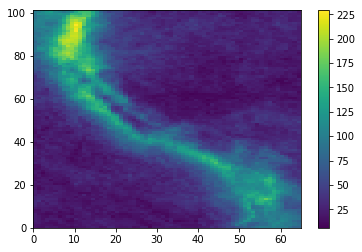

In [16]:
plt.pcolormesh(corr_end_num)
plt.colorbar()

In [17]:
def find_doy(corr_all, gt_doy=None, lt_doy=None):
    
    if gt_doy is not None:
        mask = corr_all.dayofyear>gt_doy
        pindex = 0
        rcheck = -60
    if lt_doy is not None:
        mask = corr_all.dayofyear<lt_doy
        pindex = -1
        rcheck = 60
        
    corr = corr_all.sel(dayofyear=mask)
    corr_sig = corr.where(corr['pval']<=0.05)
   
    array = corr_sig['r'].values

    thresh = 0.1
    array[array <= thresh] = 0  # T threshold maskout
    array[np.isnan(array)] = 0  # set ocean nans to 0
    outarr_3 = np.zeros((array.shape[1], array.shape[2]))
    outarr_5 = np.zeros((array.shape[1], array.shape[2]))

    for x in range(array.shape[2]):
        for y in range(array.shape[1]):
            ts = array[:,y,x]
            labels, numL = label(ts)

            u, inv = np.unique(labels, return_inverse=True)
            n = np.bincount(inv)

            inds_3 = u[(n>=3)&(u!=0)]
            inds_5 = u[(n>=5)&(u!=0)]
            

            if len(inds_3)>0:
                pos3 = np.where(labels==inds_3[pindex])
                day3 = ((corr_sig.dayofyear.values+1)[(pos3[0])[pindex]])
            else:
                day3 = np.nan

            if len(inds_5)>0:
                pos5 = np.where(labels==inds_5[pindex])
                day5 = ((corr_sig.dayofyear.values+1)[pos5[0][pindex]])
            else:
                day5 = np.nan

            if (pindex==0) & (np.sum(array[rcheck::,y,x]==0)>=40):
                day3 = np.nan
                day5 = np.nan
            if (pindex==-1) & (np.sum(array[::rcheck,y,x]==0)>=40):
                day3 = np.nan
                day5 = np.nan

            outarr_3[y,x] = day3
            outarr_5[y,x] = day5
            
    outarr_3 = xr.DataArray(outarr_3, coords=[corr['latitude'], corr['longitude']], dims=['latitude','longitude'])
    outarr_5 = xr.DataArray(outarr_5, coords=[corr['latitude'], corr['longitude']], dims=[ 'latitude','longitude'])
            
#     grid = corr.salem.grid.regrid(factor=1)
#     #ipdb.set_trace()
#     outarr_3 = grid.lookup_transform(outarr_3)
#     outarr_5 = grid.lookup_transform(outarr_5)
#     grid = grid.to_dataset()
#     outarr_3 = xr.DataArray(outarr_3, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])
#     outarr_5 = xr.DataArray(outarr_5, coords=[grid['y'], grid['x']], dims=['latitude','longitude'])

    return outarr_3, outarr_5

In [18]:
outarr_3, outarr_5 = find_doy(corr_all, gt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


In [19]:
endarr_3, endarr_5 = find_doy(corr_all, lt_doy=182)

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less_equal


NameError: name 'corr_all_num' is not defined

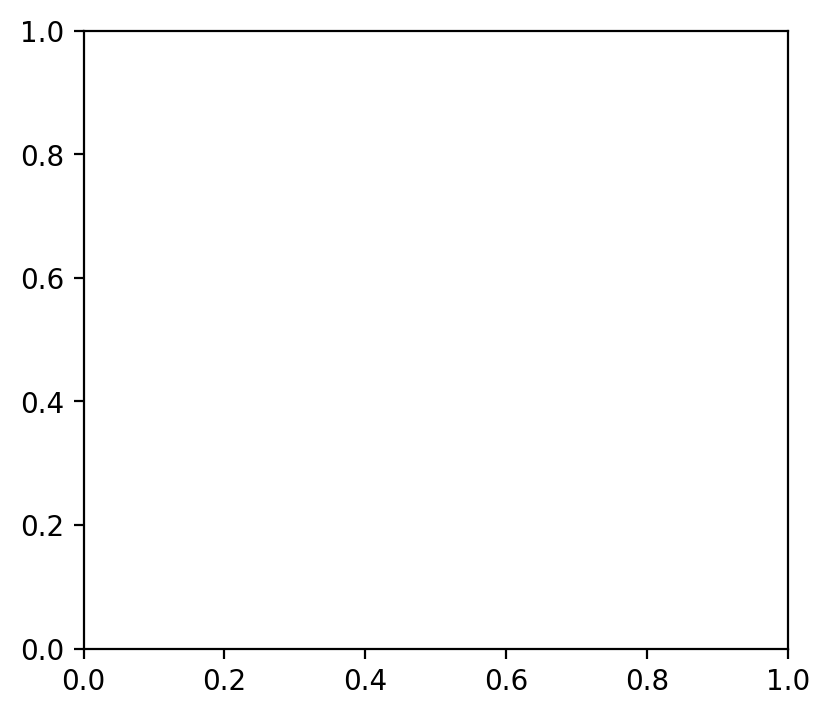

In [40]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(10,9), dpi=200)

ax = f.add_subplot(221)


map.set_data(corr_all_num, interp='linear')
map.set_plot_params(levels=np.arange(30,180,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=1)
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(222)
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(corr_end_num, interp='linear')
map.set_plot_params(levels=np.arange(30,180,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=1)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')


ax = f.add_subplot(223)
data = ((corr_end_num-corr_all_num)/corr_all_num)*100
data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-25, -15,-5, -2,2,5, 15,25], cmap='RdBu', extend='both')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=1)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')


ax = f.add_subplot(224)
data = ((corr_end_num-corr_all_num))#/corr_all_num)*100
data.values = np.array(data.values).astype(float)
data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-10, -5,-2,2, 5,10,20,30], cmap='RdBu', extend='both')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys', linewidths=1)
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')


plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_correl.png')

NameError: name 'corr_all_num' is not defined

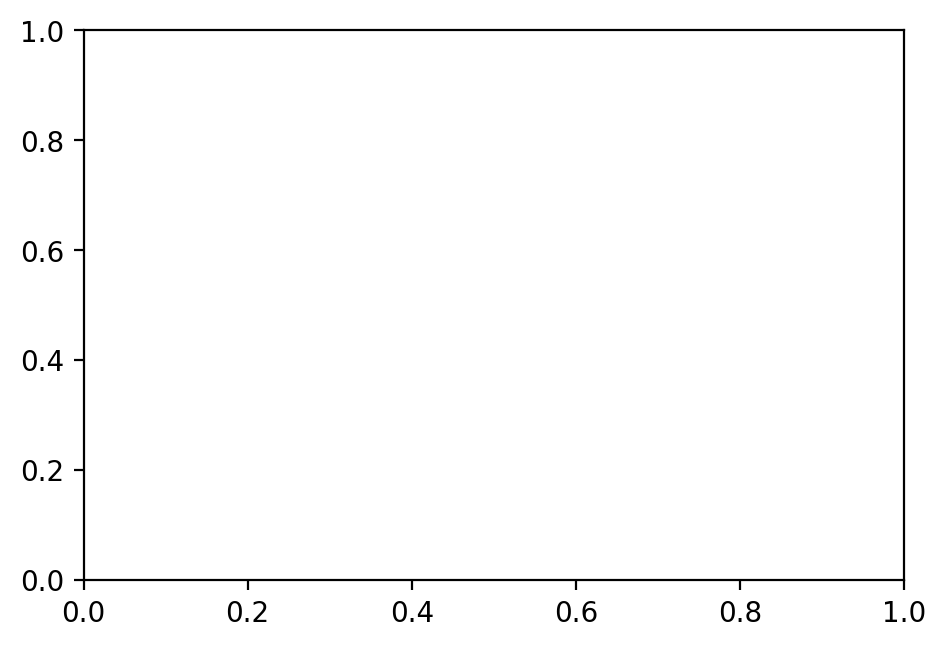

In [22]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(18,8), dpi=200)

ax = f.add_subplot(231)

map.set_data(corr_all_num)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(232)
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(corr_end_num)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
data = ((corr_end_num-corr_all_num)/corr_all_num)*100
data.values[corr_all_num.values<60]=np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-30,-20,-10, -5, 5,10,20,30], cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)

map.set_data(era_all)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(235)
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(era_end)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(236)
data = ((era_end-era_all))#/era_all)*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-10,-5,5,10,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='Percentage change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr.png')

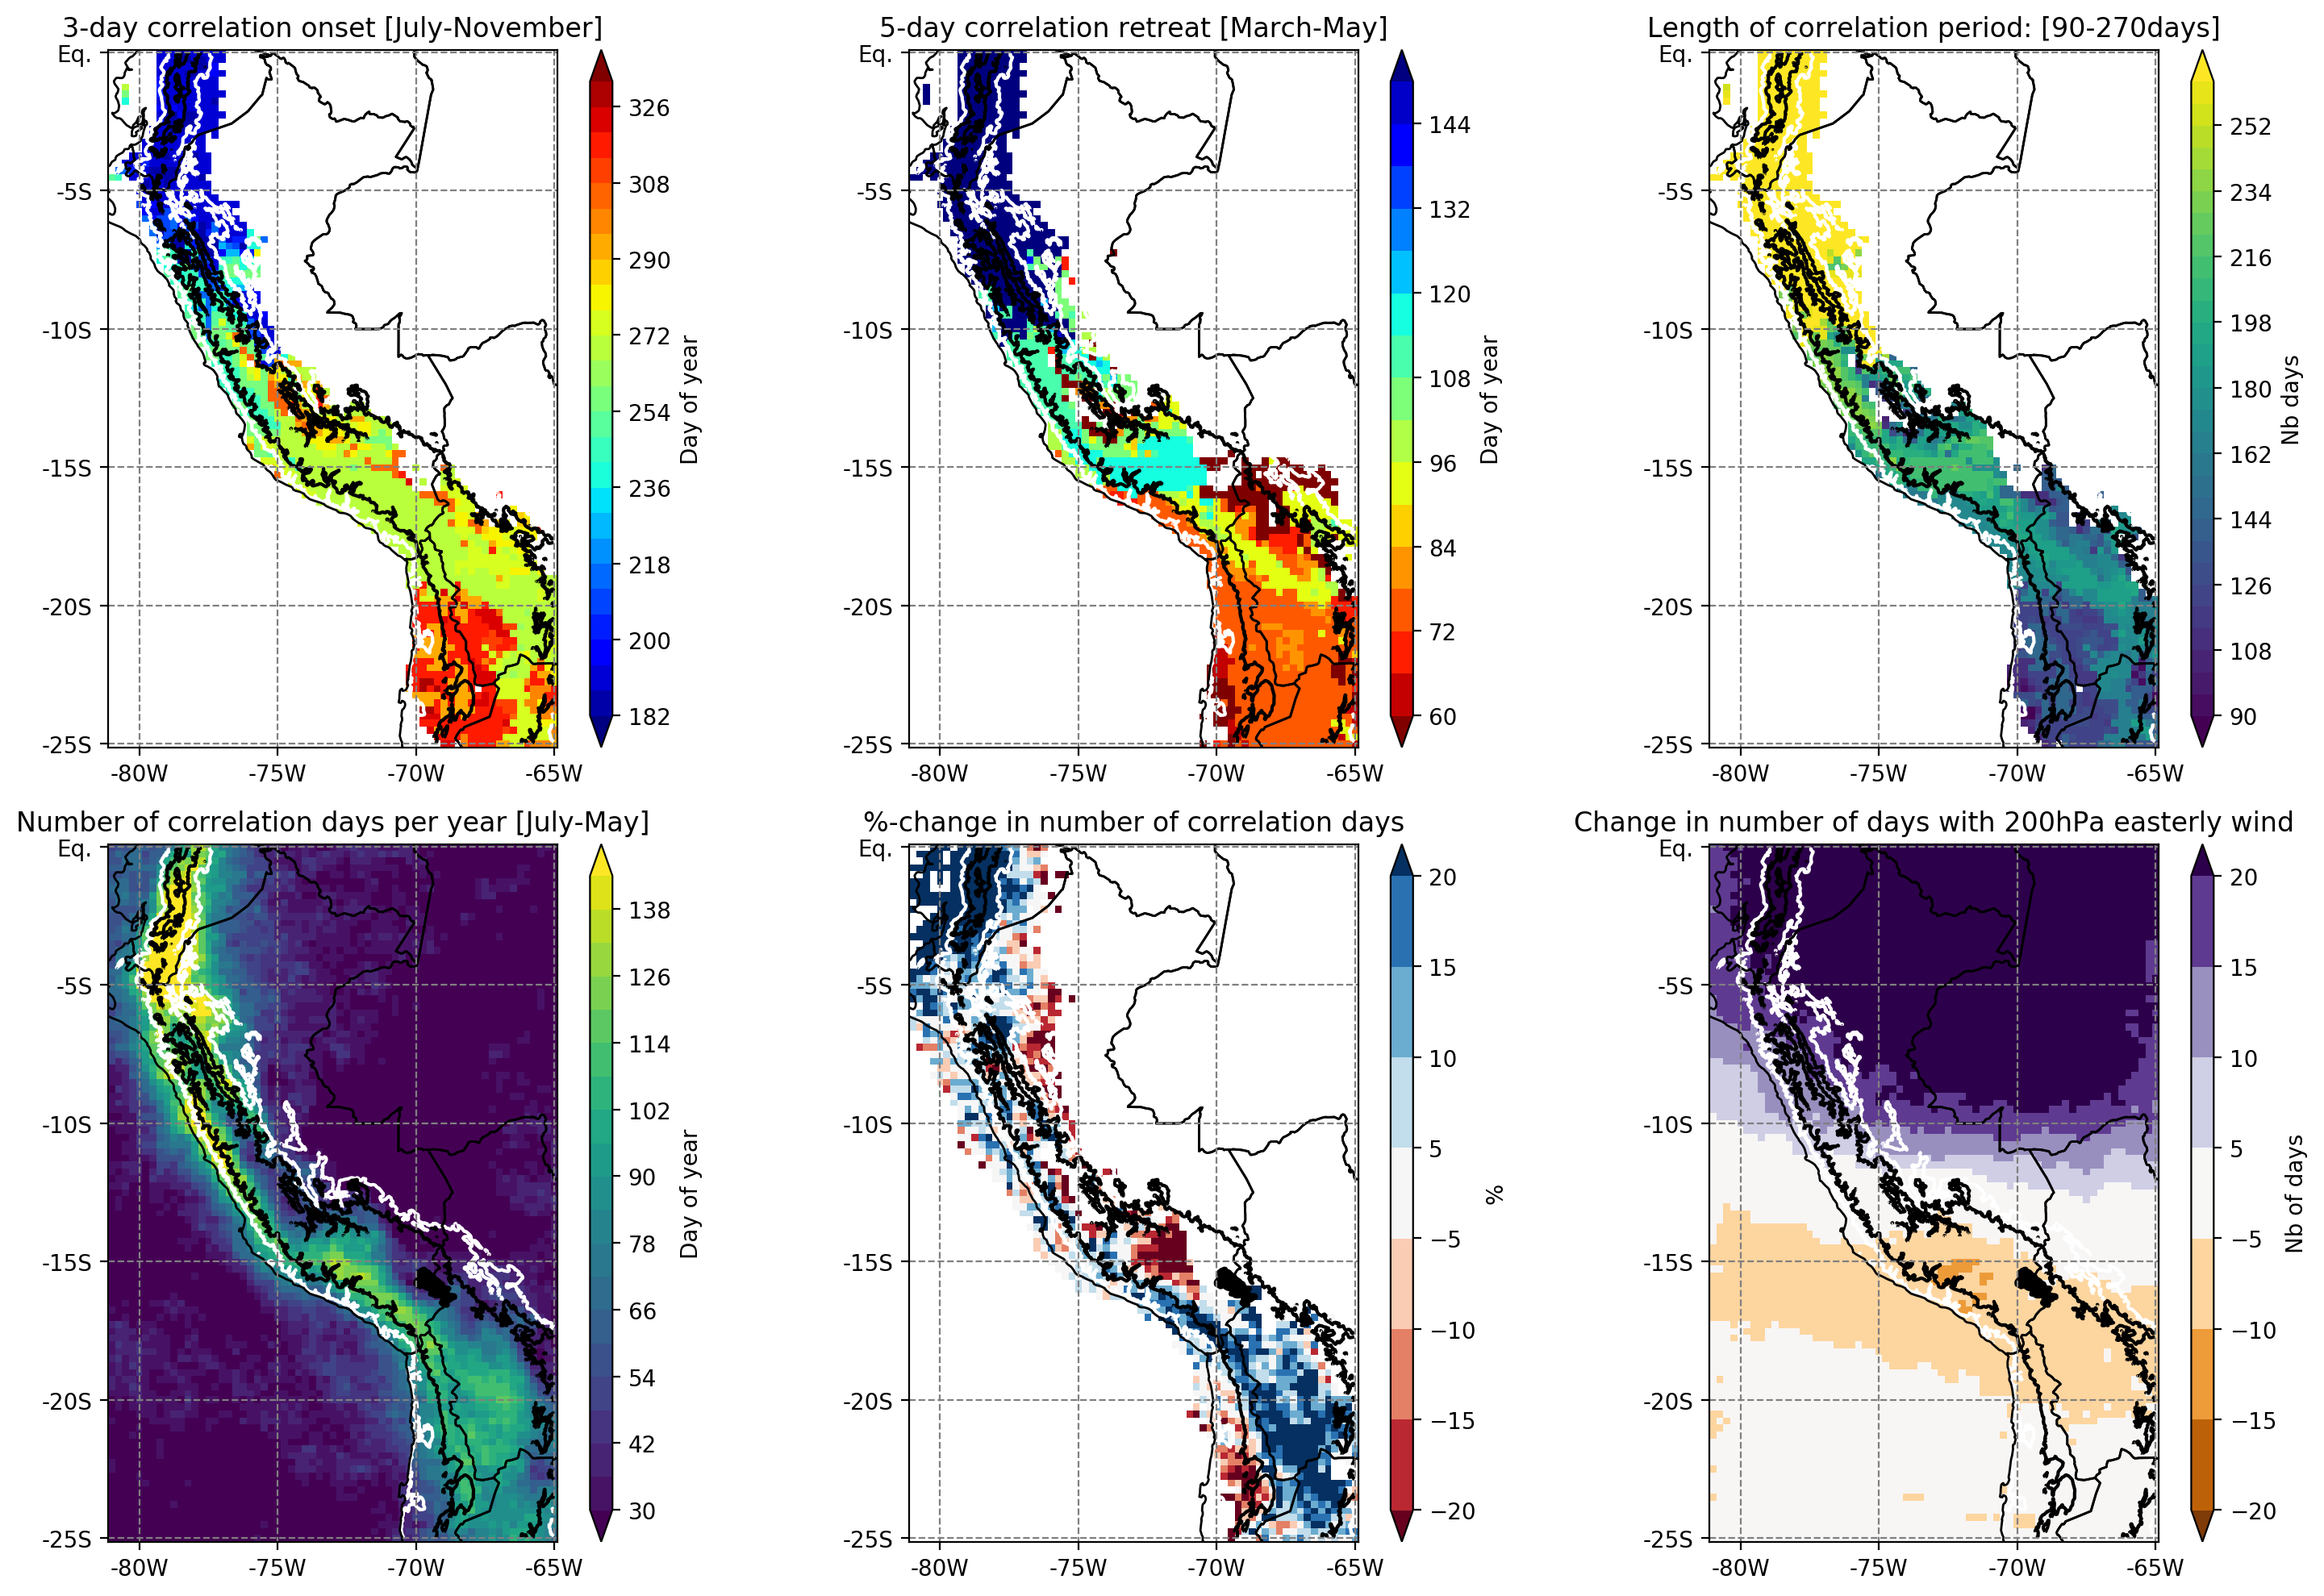

In [20]:
lakes = salem.read_shapefile(salem.get_demo_file('ne_50m_lakes.shp'),
                              cached=True)

map = corr_all.salem.get_map()
f = plt.figure(figsize=(15,10), dpi=200)

ax = f.add_subplot(231)
outarr_3.values[(topo_on_g<300)]=np.nan
map.set_data(outarr_3)
map.set_plot_params(levels=np.arange(182,335,6), cmap='jet', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='3-day correlation onset [July-November]')

ax = f.add_subplot(232)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(endarr_5)
map.set_plot_params(levels=np.arange(60,152,6), cmap='jet_r', extend='both') # 60 March, 152 June
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Day of year', title='5-day correlation retreat [March-May]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(233)
endarr_5.values[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data((365-outarr_3)+endarr_5)
map.set_plot_params(levels=np.arange(90,270,6), cmap='viridis', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb days', title='Length of correlation period: [90-270days]')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(234)

map.set_data(corr_first_num)
map.set_plot_params(levels=np.arange(30,150,6), cmap='viridis', extend='both') #[182,213,244,274,305,335, 366]  # 182-July, 335- December
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.set_shapefile(lakes, edgecolor='k', facecolor='k', linewidth=2)
plt.plot(-77.5, -9.5, 'ro', markersize=5)
map.visualize(cbar_title='Day of year', title='Number of correlation days per year [July-May]')

ax = f.add_subplot(235)
data = ((corr_end_num-corr_first_num)/corr_first_num)*100
data.values[corr_first_num.values<60]=np.nan
#data[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='RdBu', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='%', title='%-change in number of correlation days')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

ax = f.add_subplot(236)
data = ((era_end-era_all)-3)#/era_all*100
#data.values[corr_all_num.values<60]=np.nan
#endarr_5[(topo_on_g<300)]=np.nan # | (endarr_5<65)
map.set_data(data)
map.set_plot_params(levels=[-20,-15,-10, -5, 5,10,15,20], cmap='PuOr', extend='both')
map.set_contour(topo, interp='linear', levels=[900,3000], cmap='Greys')
map.visualize(cbar_title='Nb of days', title='Change in number of days with 200hPa easterly wind')
plt.plot(-77.5, -9.5, 'ro', markersize=5)

plt.tight_layout()
#plt.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/correlations/GRIDSAT_u200COUNT_CCT_numberOfDays_corr1985-2018.png')